In [ ]:
using Pkg; Pkg.add("Suppressor"); 
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev")
@suppress Pkg.add(["Dates","Plots","DataFrames"])
@info "Dependencies added"


In [1]:
using Suppressor: @suppress;
using AirBorne.ETL.YFinance: get_chart_data, parse_intraday_raw_data
using Dates: DateTime,datetime2unix
using DataFrames
#input dates as "yyyy-mm-dd"
function get_and_process_data(tickers::Vector{String}, start_date::DateTime, end_date::DateTime, freq::String)
    unix(x) = string(round(Int, datetime2unix(DateTime(x))))
    function get_data()
        df = DataFrames.DataFrame()
        for ticker in tickers
            df = DataFrames.vcat(
                df, parse_intraday_raw_data(get_chart_data(ticker, unix(start_date), unix(end_date), freq))
            )
        end
        return df
    end
    df = get_data()
    processed_data = Dict()
    for ticker in tickers
        tmp = df[df[!, "symbol"] .== ticker, :]
        weekly = tmp
        insertcols!(weekly, "t+1 close" => vcat(weekly[!, "close"][2:end], missing))
        insertcols!(weekly, "t+2 close" => vcat(weekly[!, "close"][3:end], [missing, missing]))
        insertcols!(weekly, "t+3 close" => vcat(weekly[!, "close"][4:end], [missing, missing, missing]))
        insertcols!(weekly, "t+4 close" => vcat(weekly[!, "close"][5:end], [missing, missing, missing, missing]))
        dropmissing!(weekly)
        insertcols!(weekly, "1" => weekly[!, "t+1 close"] ./ weekly[!, "close"] .- 1)
        insertcols!(weekly, "2" => (weekly[!, "t+2 close"] ./ weekly[!, "close"]).^(1/2) .- 1)
        insertcols!(weekly, "3" => (weekly[!, "t+3 close"] ./ weekly[!, "close"]).^(1/3) .- 1)
        insertcols!(weekly, "4" => (weekly[!, "t+4 close"] ./ weekly[!, "close"]).^(1/4) .- 1)
        #insertcols!(weekly, "max returns" => maximum(weekly[!, ["t+1 returns", "t+2 returns", "t+3 returns", "t+4 returns"]], dims=2))
        # maximum((weekly[!, ["t+1 returns", "t+2 returns", "t+3 returns", "t+4 returns"]], dims=2))
        processed = combine(weekly, 1:6,11,17:20, AsTable(["1", "2", "3", "4"]) .=> ByRow.(findmax) => ["max returns", "duration"] )
        conversion_func(x) = parse(Int, string(x))
        processed_data[ticker] = combine(processed, :, "duration" .=> ByRow.(conversion_func) => "duration")
    end
    return processed_data
end

get_and_process_data (generic function with 1 method)

Error in Timer:
InterruptException:


Stacktrace:
 [1] io_send_callback(name

("GOOG" => 1713×13 DataFrame
  Row │ close    high     low      open     volume   date                 symbol  1             2             3             4             max returns   duration 
      │ Float64  Float64  Float64  Float64  Int64    DateTime             String  Float64       Float64       Float64       Float64       Float64       Int64    
──────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    1 │ 139.05   139.2    138.47   138.625  1231284  2024-01-03T09:30:00  GOOG     0.00151095    0.00269324    0.000838302   0.00071838    0.00269324          2
    2 │ 139.26   139.45   138.97   139.05    334986  2024-01-03T09:35:00  GOOG     0.00387693    0.000502145   0.000454328  -0.000143842   0.00387693          1
    3 │ 139.8    139.895  139.235  139.24    479977  2024-01-03T09:40:00  GOOG    -0.0028613    -0.00125259   -0.00148052   -0.000196769  -0.000196769         4
  

207   0.0           0.00011502    0.000517354   0.000517354         4
  799 │ 144.81   144.94   144.72   144.85    324447  2024-01-18T11:00:00  GOOG     0.000276283   0.000310691   0.000782015   0.000388566   0.000782015         3
  800 │ 144.85   144.94   144.73   144.82    141674  2024-01-18T11:05:00  GOOG     0.0003451     0.00103498    0.000425997   0.000827408   0.00103498          2
  801 │ 144.9    144.94   144.7    144.84    194437  2024-01-18T11:10:00  GOOG     0.00172533    0.000466448   0.000988229   0.000950686   0.00172533          1
  802 │ 145.15   145.15   144.815  144.91    311984  2024-01-18T11:15:00  GOOG    -0.00079085    0.000619883   0.000692605   0.00036151    0.000692605         3
  803 │ 145.035  145.235  145.0    145.145   233631  2024-01-18T11:20:00  GOOG     0.00203261    0.00143516    0.000745926   0.000266726   0.00203261          1
  804 │ 145.33   145.34   144.92   145.04    280340  2024-01-18T11:25:00  GOOG     0.000838063   0.000103204  -0.00032121   -

0.000349661  -0.00031823   -0.00031823          4
 1603 │ 142.74   143.07   142.71   143.05    150697  2024-02-01T13:00:00  GOOG    -0.000875718   0.000525271   0.000275475  -0.0001752     0.000525271         2
 1604 │ 142.615  142.75   142.54   142.74    161827  2024-02-01T13:05:00  GOOG     0.00192823    0.000851568   5.84147e-5    8.58775e-5    0.00192823          1
 1605 │ 142.89   142.96   142.56   142.61    139710  2024-02-01T13:10:00  GOOG    -0.000223932  -0.000875182  -0.000527485  -0.000218771  -0.000218771         4
 1606 │ 142.858  142.885  142.75   142.88    152815  2024-02-01T13:15:00  GOOG    -0.00152601   -0.000679227  -0.000217051  -0.000872638  -0.000217051         3
 1607 │ 142.64   142.86   142.57   142.85    118760  2024-02-01T13:20:00  GOOG     0.00016827    0.00043807   -0.000654754  -0.000420915   0.00043807          2
 1608 │ 142.664  142.74   142.575  142.645   155081  2024-02-01T13:25:00  GOOG     0.000707943  -0.00106601   -0.000617233  -0.000287515   0.0007

"AAPL" => 1713×13 DataFrame
  Row │ close    high     low      open     volume    date                 symbol  1             2             3             4             max returns   duration 
      │ Float64  Float64  Float64  Float64  Int64     DateTime             String  Float64       Float64       Float64       Float64       Float64       Int64    
──────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
    1 │ 185.63   185.689  184.49   184.668   4199190  2024-01-03T09:30:00  AAPL    -0.00323227   -0.00218414   -0.000826711  -0.000788799  -0.000788799         4
    2 │ 185.03   185.88   184.95   185.64    1709860  2024-01-03T09:35:00  AAPL    -0.0011349     0.000378244   2.70208e-5   -0.000351348   0.000378244         2
    3 │ 184.82   185.19   184.71   185.035   1100128  2024-01-03T09:40:00  AAPL     0.00189368    0.00060849   -9.00263e-5    0.0           0.00189368         

::String, data::String)
   @ 

84.48   184.72   184.37   184.64     574857  2024-01-10T09:45:00  AAPL    -0.00265606   -0.000582879  -0.000723264  -0.00041384   -0.00041384          4
  395 │ 183.99   184.48   183.97   184.47     772120  2024-01-10T09:50:00  AAPL     0.00149461    0.000244539   0.000334687   0.000692391   0.00149461          1
  396 │ 184.265  184.27   183.97   183.985    436452  2024-01-10T09:55:00  AAPL    -0.00100398   -0.000244772   0.000425126   0.000332229   0.000425126         3
  397 │ 184.08   184.29   183.92   184.26     599757  2024-01-10T10:00:00  AAPL     0.000515009   0.00114044    0.000778028   0.000217231   0.00114044          2
  398 │ 184.175  184.18   183.98   184.09     476496  2024-01-10T10:05:00  AAPL     0.00176627    0.000909564   0.000117991   0.000508908   0.00176627          1
  399 │ 184.5    184.59   184.16   184.185    588255  2024-01-10T10:10:00  AAPL     5.35918e-5   -0.00070513    9.01386e-5   -3.61847e-5    9.01386e-5          3
  400 │ 184.51   184.64   184.34   18

Excessive output truncated after 542679 bytes.

VSCodeServer 

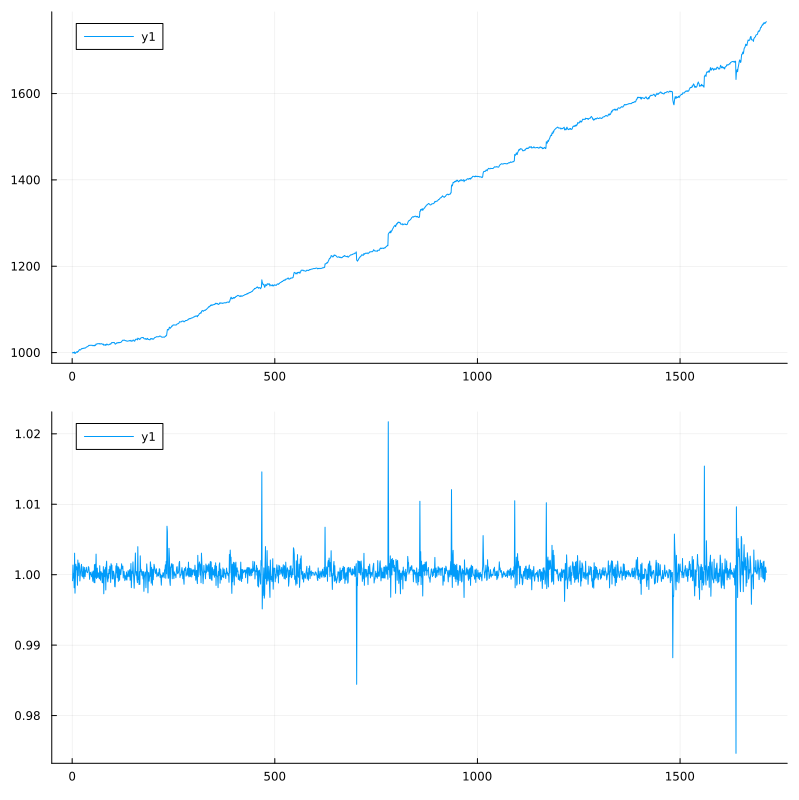

In [2]:
using DirectSearch
using Statistics: cov, var, std
using RollingFunctions: runvar, runcov, running
using Plots

series = get_and_process_data(["GOOG", "AAPL"], DateTime("2024-01-03"), DateTime("2024-02-03"), "5m")
# series = get_and_process_data(["GOOG", "AAPL"], DateTime("2022-01-01"), DateTime("2023-01-01"), "1d")
num_periods = nrow(series["GOOG"])
println("num_periods = ", num_periods)
γ_trade = 0.0
γ_risk = 1
dur = 1
curr_portfolio = [0.5, 0.5]
var_goog = runvar(series["GOOG"][!, "1"], 60)
var_aapl = runvar(series["AAPL"][!, "1"], 60)
cov_goog_aapl = running(cov, vec(series["GOOG"][!, "1"]), vec(series["AAPL"][!, "1"]), 60)
value = 1000
portfolio_returns = []
portfolio_value = []
for i = 1:num_periods
    total_ret = 1
    if dur == 1
        #objective function: maximise expected return - risk - trading costs
        obj(portfolio) = (-portfolio[1]*series["GOOG"][i, :]["max returns"] - portfolio[2]*series["AAPL"][i, :]["max returns"] 
                        + γ_risk * (portfolio[1] * var_goog[i] + portfolio[2] * var_aapl[i] + portfolio[1] * portfolio[2] * cov_goog_aapl[i])
                        + γ_trade * (abs(portfolio[1] - curr_portfolio[1]) + abs(portfolio[2] - curr_portfolio[2])))
        p = DSProblem(2, objective=obj, lower=[0.,0.], upper=[1.,1.])
        valcond(x) = (x[1] + x[2]) == 1
        buyonly(x) = x[1] >= 0 && x[2] >= 0
        duration(x) = x[1]*series["GOOG"][i, :]["duration"] + x[2]*series["AAPL"][i, :]["duration"] >= 1
        AddExtremeConstraint(p, buyonly)
        AddExtremeConstraint(p, valcond)
        SetGranularity(p, [0.01, 0.01])
        SetInitialPoint(p, [0.50, 0.50])
        @suppress Optimize!(p)
        dur = round(Int, p.x[1] * series["GOOG"][i, :]["duration"] + p.x[2] * series["AAPL"][i, :]["duration"])
        dur == 0 ? dur = 1 : dur = dur
        # println("duration = ", dur)
        returns = ((series["GOOG"][i, :]["1"]) * p.x[1] + series["AAPL"][i, :]["1"] * p.x[2])
        total_ret = (1 + returns) * (1 - γ_trade * (abs(p.x[1] - curr_portfolio[1]) + abs(p.x[2] - curr_portfolio[2])))
        value *= total_ret
        curr_portfolio = p.x
    else
        returns = (series["GOOG"][i, :]["1"] * curr_portfolio[1] + series["AAPL"][i, :]["1"] * curr_portfolio[2])
        total_ret = 1 + returns
        value *= total_ret
        dur -= 1
    end
    push!(portfolio_value,value)
    push!(portfolio_returns, total_ret)
end
println("final value = ", value)
println("portfolio_returns_std = ", std(portfolio_returns))
val = plot(portfolio_value)
ret = plot(portfolio_returns)
plot(val, ret, layout=(2,1), size=(800, 800))